#  **Importing the necessary Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
import os
from pathlib import Path
import requests
from PIL import Image
import random

In [4]:
# Used for random seeds generation

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Downloading the Pre-trained Model : ViT-B-16**

In [6]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
class_names = ['Microscopy','Macroscopy','FACS','Non-scientific','Blot/Gel','Histopathology']

set_seeds()
import torch.nn.functional as F

pretrained_vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(in_features=512, out_features=6)
).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 157MB/s]  


# **Model's Summary**

In [7]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(64, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]    [64, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [64, 197, 768]       [64, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (layers)                                   [64, 197, 768]       [64, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]       [64, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]       [64, 

In [9]:
# Train-test split

train_dir="/kaggle/input/splitdata/train"
test_dir="/kaggle/input/splitdata/test"

In [10]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# **DataLoaders**

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
    return train_dataloader, test_dataloader, class_names

In [12]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=pretrained_vit_transforms,batch_size=64) 
print("Class Names:", class_names)

Class Names: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']


In [13]:
train_length = len(train_dataloader_pretrained.dataset)
test_length = len(test_dataloader_pretrained.dataset)

print("Number of images in train DataLoader:", train_length)
print("Number of images in test DataLoader:", test_length)

Number of images in train DataLoader: 8326
Number of images in test DataLoader: 2128


In [14]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval() 
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


# **Training Process**

In [15]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=35,
                                      device=device)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1785 | train_acc: 0.9530 | test_loss: 0.0481 | test_acc: 0.9881
Epoch: 2 | train_loss: 0.0378 | train_acc: 0.9895 | test_loss: 0.0312 | test_acc: 0.9908
Epoch: 3 | train_loss: 0.0239 | train_acc: 0.9939 | test_loss: 0.0303 | test_acc: 0.9908
Epoch: 4 | train_loss: 0.0194 | train_acc: 0.9930 | test_loss: 0.0274 | test_acc: 0.9922
Epoch: 5 | train_loss: 0.0126 | train_acc: 0.9963 | test_loss: 0.0391 | test_acc: 0.9917
Epoch: 6 | train_loss: 0.0103 | train_acc: 0.9973 | test_loss: 0.0234 | test_acc: 0.9931
Epoch: 7 | train_loss: 0.0079 | train_acc: 0.9974 | test_loss: 0.0275 | test_acc: 0.9936
Epoch: 8 | train_loss: 0.0065 | train_acc: 0.9979 | test_loss: 0.0257 | test_acc: 0.9954
Epoch: 9 | train_loss: 0.0078 | train_acc: 0.9982 | test_loss: 0.0308 | test_acc: 0.9908
Epoch: 10 | train_loss: 0.0062 | train_acc: 0.9979 | test_loss: 0.0361 | test_acc: 0.9926
Epoch: 11 | train_loss: 0.0105 | train_acc: 0.9976 | test_loss: 0.0303 | test_acc: 0.9936
Epoch: 12 | train_l

# Plot Loss Curves

In [16]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

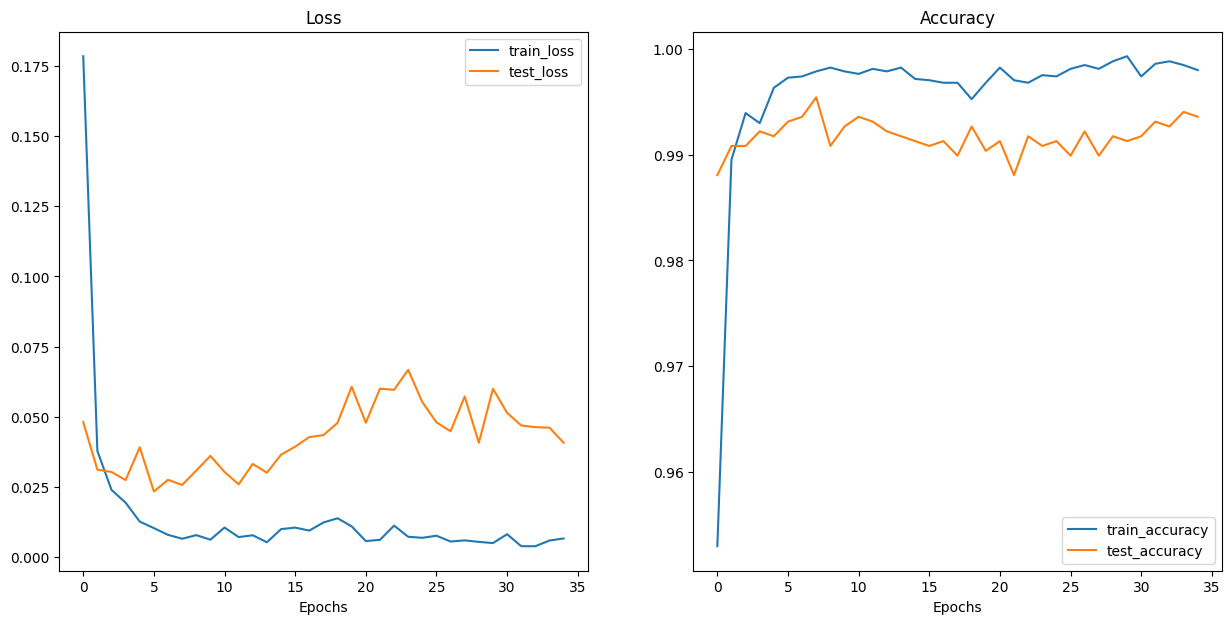

In [17]:
plot_loss_curves(pretrained_vit_results) 

# Results

Accuracy: 0.9934
Precision: 0.9931
Recall: 0.9938
F1 Score: 0.9935
Computation Time: 12.55 seconds
Confusion Matrix:
[[378   0   0   1   0   0]
 [  0 218   0   0   0   0]
 [  0   0 392   0   2   0]
 [  2   0   1 427   3   1]
 [  0   1   3   0 297   0]
 [  0   0   0   0   0 402]]


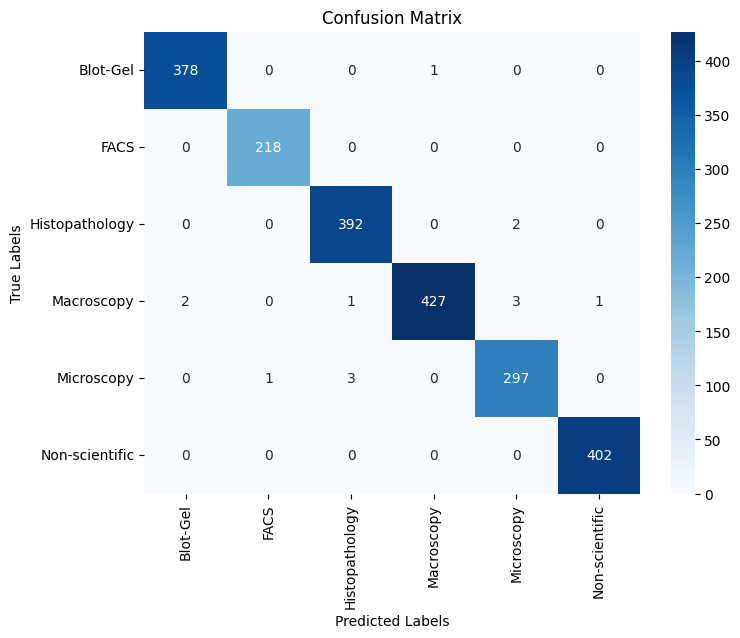

In [19]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    end_time = time.time()
    computation_time = end_time - start_time

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Computation Time: {computation_time:.2f} seconds')

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']

evaluate_model(pretrained_vit, test_dataloader_pretrained, device, class_names)


# Download model

In [20]:
model_path = '/kaggle/working/pretrained_vit_model.pth'
weights_path = '/kaggle/working/pretrained_vit_weights.pth'

torch.save(pretrained_vit, model_path)

torch.save(pretrained_vit.state_dict(), weights_path)

# Predictions on any user input image

In [33]:
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):

    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False) 
    

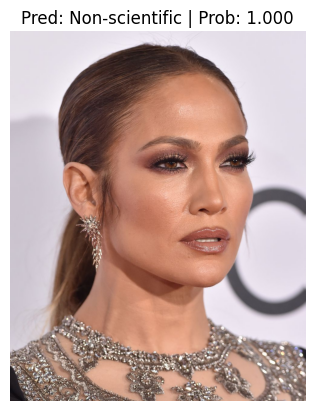

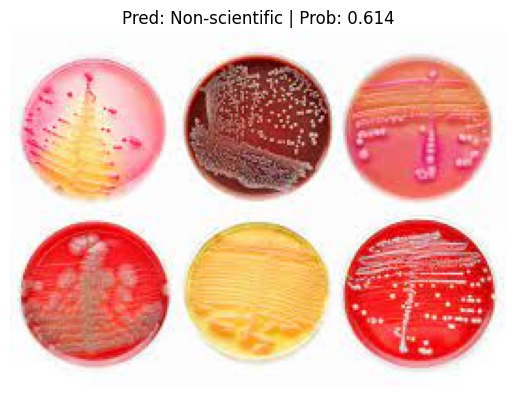

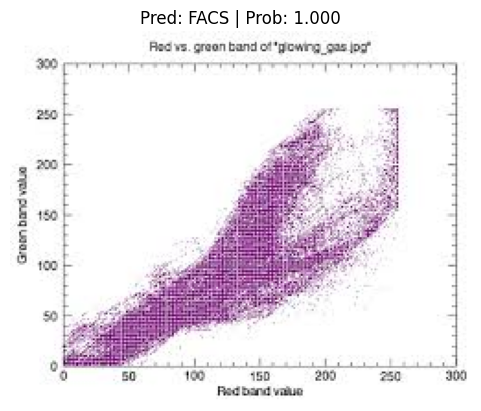

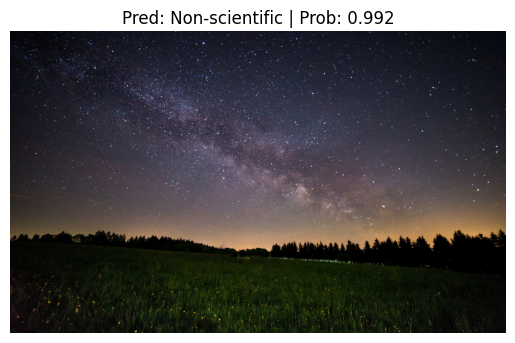

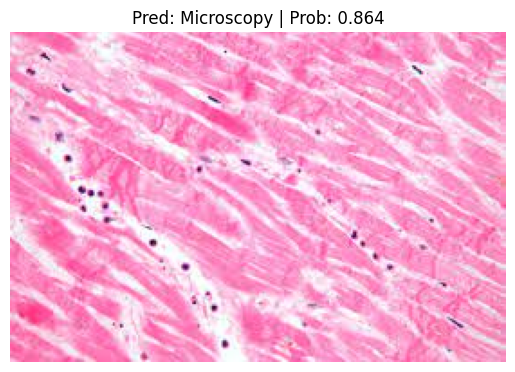

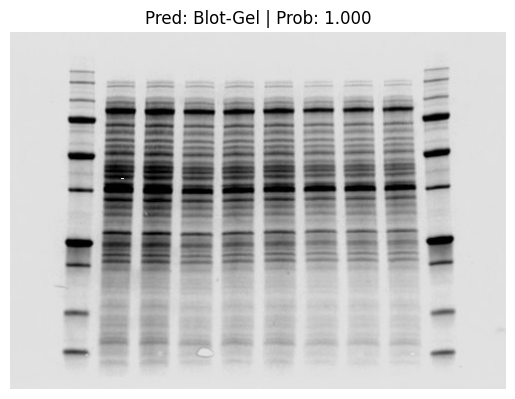

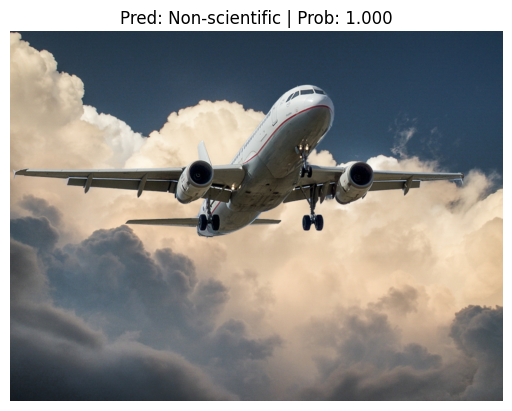

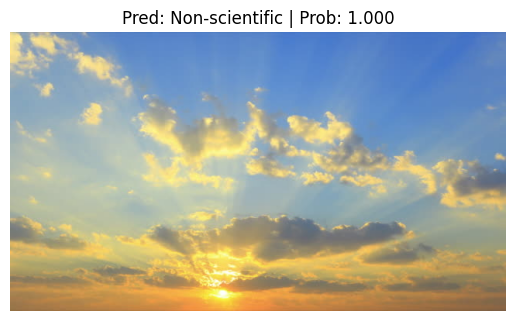

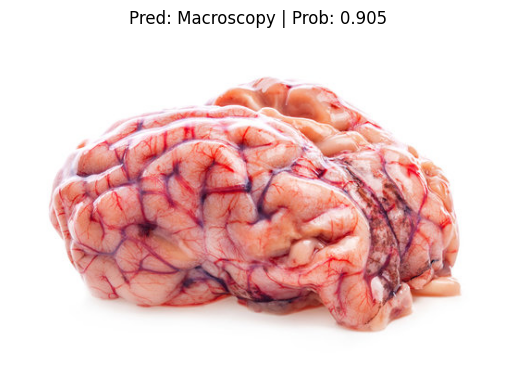

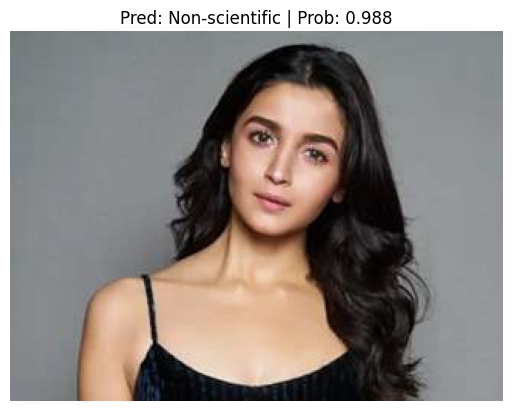

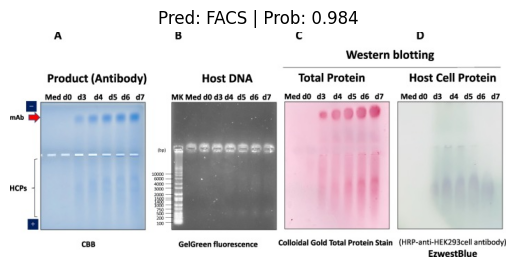

In [39]:
model = torch.load('/kaggle/input/vit-transformer/pytorch/vit-transformer/1/pretrained_vit_model.pth')  
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

model.to(device)

class_names = ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']
folder_path = '/kaggle/input/customimg/customimages'

for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)    
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names)
